In [1]:
%matplotlib inline

In [2]:
import ifc_utils
import keras
import numpy
import matplotlib.pyplot
import os.path
import pandas

Using TensorFlow backend.


In [3]:
directory = "data/processed"

data = {
    "abnormal": "data/raw/abnormal",
    "normal": "data/raw/normal"
}

channels = [0, 2, 5, 6, 11]

split = 0.8

In [4]:
ifc_utils.parse(directory, data, channels)

ifc_utils.split(directory, data, split)

class_weights = ifc_utils.class_weights(directory, data)

In [5]:
shape = (32, 32, 1)

x = keras.layers.Input(shape)

In [6]:
classes = 2

The classifier architecture is adapted from the LeNet-5 convolutional neural network by Yann LeCunn, et al.

In [7]:
options = {"activation": "relu", "kernel_size": (3, 3)}

y = keras.layers.Conv2D(32, **options)(x)
y = keras.layers.Conv2D(64, **options)(y)

y = keras.layers.MaxPooling2D()(y)

y = keras.layers.Dropout(0.5)(y)

y = keras.layers.Flatten()(y)

y = keras.layers.Dense(128, activation="relu")(y)

y = keras.layers.Dropout(0.5)(y)

y = keras.layers.Dense(classes)(y)

y = keras.layers.Activation("softmax")(y)

/usr/local/lib/python3.5/site-packages/keras/utils/generic_utils.py:135: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  arg_spec = inspect.getargspec(cls.from_config)


In [8]:
model = keras.models.Model(x, y)

In [9]:
loss = keras.losses.categorical_crossentropy

optimizer = keras.optimizers.Adam(0.0001)

model.compile(
    loss=loss, 
    metrics=[
        "accuracy"
    ],
    optimizer=optimizer
)

In [10]:
training_x = numpy.load(os.path.join(directory, "training_x.npy"))

training_y = numpy.load(os.path.join(directory, "training_y.npy"))

In [11]:
csv_logger = keras.callbacks.CSVLogger("training.csv")

early_stopping = keras.callbacks.EarlyStopping(patience=32)

model_checkpoint = keras.callbacks.ModelCheckpoint("checkpoint.hdf5")

reduce_learning_rate_on_plateau = keras.callbacks.ReduceLROnPlateau()

In [12]:
options = {
    "batch_size": 4096,
    "class_weight": class_weights,
    "callbacks": [
        csv_logger,
        early_stopping,
        model_checkpoint,
        reduce_learning_rate_on_plateau
    ],
    "epochs": 256,
    "validation_split": 0.25,
    "verbose": 0,
    "x": training_x,
    "y": training_y    
}

%time model.fit(**options)

CPU times: user 1min 54s, sys: 1min 16s, total: 3min 11s
Wall time: 3min 46s


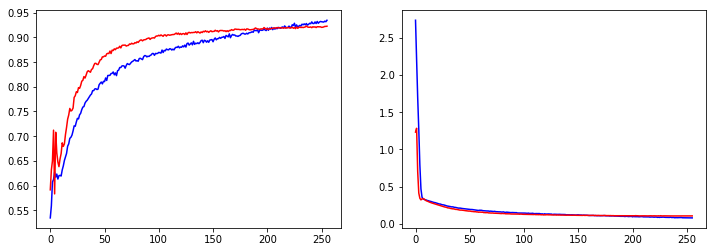

In [13]:
observations = pandas.read_csv("training.csv")

_, (a, b) = matplotlib.pyplot.subplots(nrows=1, ncols=2, figsize=(12, 4))

a.plot(observations["acc"], "b")
a.plot(observations["val_acc"], "r")

b.plot(observations["loss"], "b")
b.plot(observations["val_loss"], "r")

In [14]:
model.load_weights("./checkpoint.hdf5")

In [16]:
test_x = numpy.load(os.path.join(directory, "test_x.npy"))

test_y = numpy.load(os.path.join(directory, "test_y.npy"))

In [17]:
model.evaluate(test_x, test_y)

4704/4745 [============================>.] - ETA: 0s

[0.23072426149541134, 0.91675447841087554]